In [1]:
import pandas as pd
from surprise import Reader, Dataset, accuracy
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate
from tqdm.notebook import tqdm
from surprise.model_selection import train_test_split


## Carrega dados dos matches
Desenvolvidos no notebook match preprocess.ipynb

In [2]:
df_rating = pd.read_csv("../data/matches2.csv")

In [3]:
df_rating.drop(columns=['Unnamed: 0'], inplace=True)
print(df_rating.shape)
df_rating.head()

(21000000, 3)


,id_posicao,id_trabalhador,rating
0,d93af0f9-a8ab-4715-b35e-5639112e620e,1268017,0
1,55fd4744-b20f-4c07-ad27-332f1ebb580c,1268017,1
2,b3cb53ef-36ad-4999-ba8a-d22cb9a0e33e,1268017,1
3,696a1e3f-b335-451d-b51e-e1d32c823fc0,1268017,1
4,362be614-4d3c-40db-a0be-67b742002b14,1268017,1


### Distribuição das notas de associação entre os trabalhadores e as posições

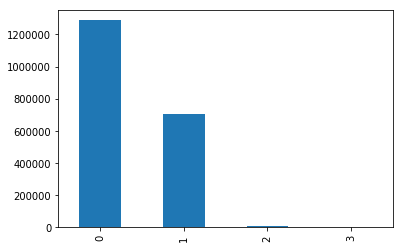

In [56]:
df_rating.rating.value_counts().plot.bar();

In [5]:
#df_rating[df_rating['rating']==0].shape
df_rating = df_rating.sample(2000000)

In [30]:
reader = Reader(rating_scale=(0, 3))
data = Dataset.load_from_df(df_rating[['id_trabalhador','id_posicao','rating']], reader)


In [7]:
# del(df_rating)

## Avalia alguns modelos

In [9]:
list_models = [SVD(), NormalPredictor(), KNNBasic(), CoClustering()]

benchmark = []
# Iterate over all algorithms

for algorithm in tqdm(list_models, total=len(list_models)):
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.



,test_rmse,fit_time,test_time
Algorithm,,,
KNNBasic,0.114385,13.653772,127.607379
CoClustering,0.135676,36.671393,7.835327
SVD,0.140370,56.657467,6.466326
NormalPredictor,0.627388,2.598963,6.717974


## Escolhe o modelo com melhor desempenho

In [31]:
trainset, testset = train_test_split(data, test_size=.25)

In [32]:
algo = KNNBasic()
algo.fit(trainset)
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [33]:
accuracy.rmse(predictions)

RMSE: 0.1013


0.10132604049237633

In [34]:
predictions

[Prediction(uid=2666308, iid='5ff9efc2-6046-403f-9e9a-a6432a4927b5', r_ui=0.0, est=0.025, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=1171372, iid='bc47df8b-9d70-4fc8-8c8d-5ffcfe6dad1e', r_ui=1.0, est=1.0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=1653241, iid='b0749940-b00c-4441-89ea-51443a5a9254', r_ui=1.0, est=1.0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3616075, iid='9493e1dc-daa0-4aac-8007-32033cea48e7', r_ui=0.0, est=0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=637395, iid='b89edffa-b3bb-4bc7-92c1-743e5548b9f0', r_ui=1.0, est=1.0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=703266, iid='e575bdec-abfb-4406-b6de-4ef617e4aaf0', r_ui=0.0, est=0.025, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=1836150, iid='c81cca18-1ff8-4be5-bead-bc5b252261a8', r_ui=0.0, est=0, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=143169

## Testa previsão de match com os dados brutos

In [35]:
df_rating[:1]

,id_posicao,id_trabalhador,rating
8597691,35a2559a-4fec-485c-80a0-d0bb5d2efd28,2829159,0


In [47]:
id_posicao = str('c2b5abaa-0cc1-4124-9469-0a017beb319f')
id_trabalhador = 473833
algo.predict(id_trabalhador, id_posicao)

Prediction(uid=473833, iid='c2b5abaa-0cc1-4124-9469-0a017beb319f', r_ui=None, est=1.0, details={'actual_k': 40, 'was_impossible': False})

In [74]:
rating_results = []
for index, row in df_rating[:500000].iterrows():
    id_posicao = str(row.id_posicao)
    id_trabalhador = row.id_trabalhador
    #print(algo.predict(id_trabalhador, id_posicao))
    prediction_rating = algo.predict(id_trabalhador, id_posicao).est
    rating_results.append({'id_posicao':id_posicao,'id_trabalhador':id_trabalhador, 'prediction_rating':prediction_rating})

In [75]:
df_results = pd.DataFrame(rating_results)
print(df_results.shape)
df_results.head()

(500000, 3)


,id_posicao,id_trabalhador,prediction_rating
0,35a2559a-4fec-485c-80a0-d0bb5d2efd28,2829159,0.000
1,a089afdf-b1fa-4252-a54d-e44c2646ad80,1631537,1.000
2,31abde7f-8b6d-4dce-857e-2e74c4ae66b1,3579494,0.000
3,b21ddb18-15f7-42c1-bfcf-475c98ab8b65,2584834,0.000
4,a607189b-79aa-4ea7-806e-1818fdb287a9,278344,0.025


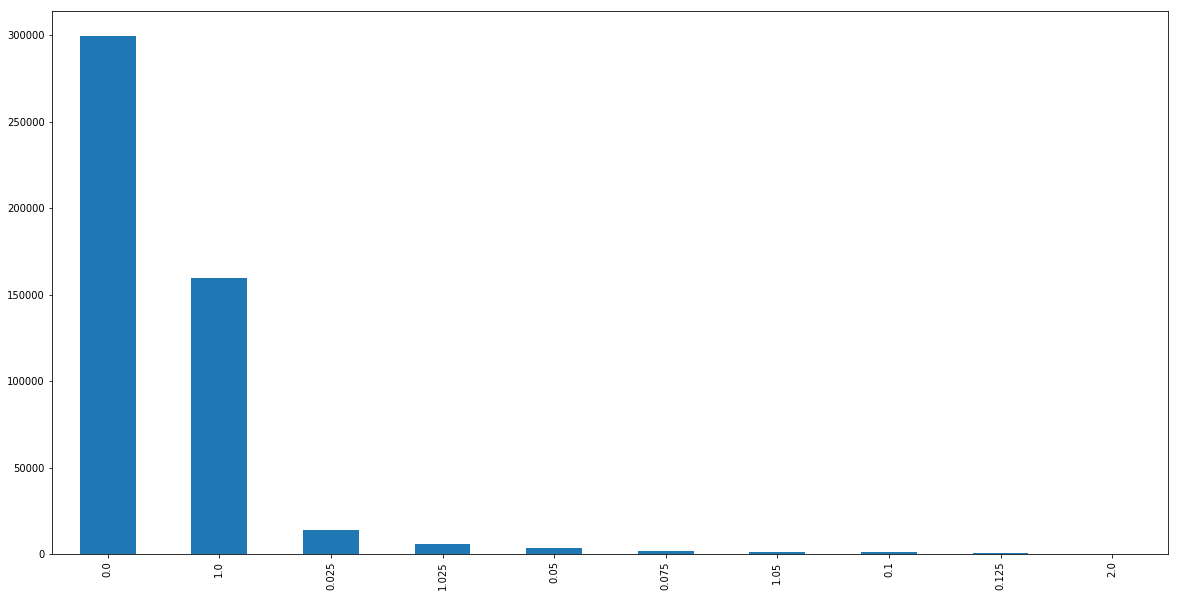

In [76]:
df_results.prediction_rating.value_counts()[:2].plot.bar(figsize=(20,10));

In [77]:
df_results.prediction_rating.value_counts()[:2]

0.000    299346
1.000    159828
0.025     13777
1.025      5942
0.050      3841
0.075      1772
1.050      1177
0.100      1001
0.125       547
2.000       345
Name: prediction_rating, dtype: int64

In [78]:
df_results.head()

,id_posicao,id_trabalhador,prediction_rating
0,35a2559a-4fec-485c-80a0-d0bb5d2efd28,2829159,0.000
1,a089afdf-b1fa-4252-a54d-e44c2646ad80,1631537,1.000
2,31abde7f-8b6d-4dce-857e-2e74c4ae66b1,3579494,0.000
3,b21ddb18-15f7-42c1-bfcf-475c98ab8b65,2584834,0.000
4,a607189b-79aa-4ea7-806e-1818fdb287a9,278344,0.025


### Procura as melhores sugestões para um trabalhador

In [83]:
df_trabalhadores = pd.read_csv("../data/D_ETL_IMO_EXTRACAO_SINE_ABERTO_TRABALHADORES_SP.csv", sep=";", encoding="iso8859-1")

/home/chris/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [87]:
df_trabalhadores['id'] = df_trabalhadores.index
df_trabalhadores[df_trabalhadores['id']==2829159]

,NACIONALIDADE,DEFICIENCIAS,BAIRRO,CEP,CODIGO_MUNICIPIO_IBGE,NOME_MUNICIPIO,UF,ESCOLARIDADE,ESTUDANTE,CURSOS_PROFISSIONALIZANTES,...,POS_GRADUACOES,IDIOMAS,HABILITACAO,VEICULOS,DISP_VIAJAR,DISP_DORMIR_EMP,DISP_AUSENTAR_DOMIC,PRETENSOES,MUNICIPIOS_INTERESSE,id
2829159,BRASILEIRA,NaN,JARDIM SANTA CECILIA,7123240,351880,GUARULHOS,SP,Médio Completo,N,NaN,...,NaN,NaN,B,N,N,N,N,"411005-Auxiliar de escritorio(N,21,0,Indiferen...",NaN,2829159


In [88]:
df_results[df_results['id_trabalhador']==2829159].sort_values(by=['prediction_rating'], ascending=False).head(10)

,id_posicao,id_trabalhador,prediction_rating
377906,3cf2dc01-06e8-4778-aa4e-730c72df4a19,2829159,1.050
417303,6062c389-783d-4922-8e98-9f1813e7559b,2829159,1.025
212486,04bab172-78fe-409c-8e5e-e304b3864919,2829159,1.000
300858,5409dfa5-5a80-4e22-8b47-129bf95d50cc,2829159,1.000
187703,687221f0-342a-48c7-a041-94f625929454,2829159,1.000
202658,7df99891-2b22-4c45-8200-79a7b04b1c06,2829159,1.000
207020,5a740b12-f25c-4e3b-af03-3f029c58bcd6,2829159,1.000
210710,6e6d9de8-e66d-4dee-9ba1-000b45e11148,2829159,1.000
221177,cc6fa491-3c58-40d1-b292-9a9c6614378e,2829159,1.000
223521,27cc20b2-467a-447a-92bd-ca8111df2deb,2829159,1.000


In [89]:
del(df_trabalhadores)

### Procura os melhores trabalhadores para uma posição

In [91]:
df_vagas = pd.read_csv("../data/vagas_mock.csv")

In [93]:
df_vagas[df_vagas['id_empresa']=='8420aae7-7128-4120-b915-249587933cd2']

,cidade,escolaridade,graduacao,id_empresa,industria,nome_empresa,posicao
15857,SAO VICENTE,Médio Completo,Nenhum,8420aae7-7128-4120-b915-249587933cd2,Energia,extend holistic partnerships,414140-Auxiliar de logistica


In [94]:
df_results[df_results['id_posicao']=='8420aae7-7128-4120-b915-249587933cd2'].sort_values(by=['prediction_rating'], ascending=False).head(10)

,id_posicao,id_trabalhador,prediction_rating
176210,8420aae7-7128-4120-b915-249587933cd2,895873,1.052199
216535,8420aae7-7128-4120-b915-249587933cd2,3487109,1.025000
221883,8420aae7-7128-4120-b915-249587933cd2,485992,1.025000
123148,8420aae7-7128-4120-b915-249587933cd2,2258357,1.025000
445780,8420aae7-7128-4120-b915-249587933cd2,2538712,1.025000
444970,8420aae7-7128-4120-b915-249587933cd2,2582524,1.025000
164603,8420aae7-7128-4120-b915-249587933cd2,18424,1.025000
168311,8420aae7-7128-4120-b915-249587933cd2,3589027,1.025000
443095,8420aae7-7128-4120-b915-249587933cd2,1393674,1.025000
196017,8420aae7-7128-4120-b915-249587933cd2,1249371,1.025000
